In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from keras.layers import Flatten, Input
from keras.layers import Embedding
from keras.layers import concatenate
from keras.utils import to_categorical
from keras.layers.wrappers import Bidirectional

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [ ]:
data_df = pd.read_csv("/content/drive/MyDrive/ISEAR.csv", names=["SN", "Class","Sentences"], index_col = "SN")

In [ ]:
data_df.Class.value_counts()

joy        1082
sadness    1074
anger      1069
fear       1063
shame      1059
disgust    1059
guilt      1040
Name: Class, dtype: int64

In [ ]:
row,col = data_df.shape

texts =[]
for i in range(0, row):
    texts.append(data_df.Sentences[i])

In [ ]:
MAX_NB_WORDS=10000
MAX_SEQ_LEN = 178

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("Found %s unique tokens",len(word_index))

data = pad_sequences(sequences, maxlen = MAX_SEQ_LEN)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found %s unique tokens 9065


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(data_df.Class)

In [ ]:
from keras. utils import to_categorical

y = to_categorical(np.asarray(y))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size =0.2, random_state = 40)

[n_samp, inp_shape] = X_train.shape

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(5956, 178)
(1490, 178)
(5956, 7)
(1490, 7)


In [ ]:
!pip install wget
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=d78fcaaa2cbac2e7227bf81f87f420be7c9e233fe469fc11c4eb590bb2171994
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
--2021-05-02 15:41:02--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.65.198
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.65.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  63.8MB/s    in 23s     

2021-05-02 15:41:26 (67.4 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
import gensim
from gensim.models import Word2Vec

embeddings_wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary = True)
embeddings_wv.init_sims(replace= True)

In [ ]:
vocab = tokenizer.sequences_to_texts(sequences)
vocab[:5]


['on days when i feel close to my partner and other friends when i feel at peace with myself and also experience a close contact with people whom i regard greatly',
 'every time i imagine that someone i love or i could contact a serious illness even death',
 'when i had been obviously unjustly treated and had no possibility of elucidating this',
 'when i think about the short time that we live and relate it to the periods of my life when i think that i did not use this short time',
 'at a gathering i found myself involuntarily sitting next to two people who expressed opinions that i considered very low and discriminating']

In [ ]:
vocab = tokenizer.sequences_to_texts(sequences)

vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

embedding_matrix = np.zeros((vocab_size, 178))

for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = embeddings_wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        pass

9066


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 178)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 178, 178)          1613748   
_________________________________________________________________
flatten_1 (Flatten)          (None, 31684)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               3168500   
_________________________________________________________________
dense_5 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 231       
Total params: 4,785,711
Trainable params: 4,785,711
Non-trainable params: 0
_________________________________________________

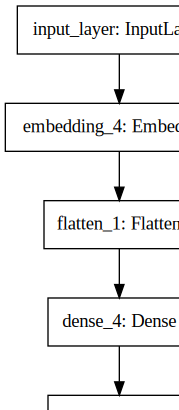

In [ ]:
model = Sequential()

Embed_Layer = Embedding(vocab_size, 178, weights= [embedding_matrix], input_length=(MAX_SEQ_LEN,), trainable = True)

input_layer = Input(shape=(MAX_SEQ_LEN,), dtype = 'int32', name='input_layer')
embedding_layer = Embed_Layer(input_layer)
Flatten_layer = Flatten()
flatten_layer = Flatten_layer(embedding_layer)
output_size = 7

dense1 = Dense(100, activation='relu')(flatten_layer)
dense2 = Dense(32, activation='relu')(dense1)
predict_layer = Dense(7, activation='softmax')(dense2)

model = Model(inputs = [input_layer], outputs = [predict_layer])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
history = model.fit(X_train, y_train, epochs = 30, batch_size=32, verbose=True, validation_data=(X_test, y_test))

Epoch 1/30
187/187 [==============================] - 11s 58ms/step - loss: 1.9458 - acc: 0.1517 - val_loss: 1.9464 - val_acc: 0.1295
Epoch 2/30
187/187 [==============================] - 10s 55ms/step - loss: 1.9459 - acc: 0.1487 - val_loss: 1.9466 - val_acc: 0.1295
Epoch 3/30
187/187 [==============================] - 10s 56ms/step - loss: 1.9455 - acc: 0.1515 - val_loss: 1.9469 - val_acc: 0.1295
Epoch 4/30
187/187 [==============================] - 10s 56ms/step - loss: 1.9460 - acc: 0.1407 - val_loss: 1.9471 - val_acc: 0.1295
Epoch 5/30
187/187 [==============================] - 10s 55ms/step - loss: 1.9461 - acc: 0.1370 - val_loss: 1.9472 - val_acc: 0.1295
Epoch 6/30
187/187 [==============================] - 11s 56ms/step - loss: 1.9460 - acc: 0.1416 - val_loss: 1.9473 - val_acc: 0.1295
Epoch 7/30
187/187 [==============================] - 11s 58ms/step - loss: 1.9452 - acc: 0.1566 - val_loss: 1.9472 - val_acc: 0.1295
Epoch 8/30
187/187 [==============================] - 11s 57ms

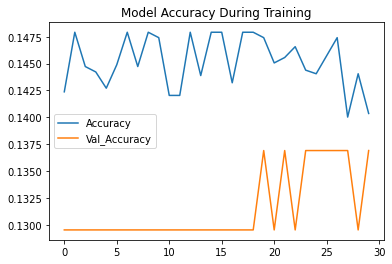

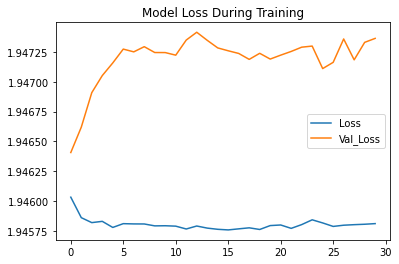

In [ ]:
plt.title("Model Accuracy During Training")
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Val_Accuracy')
plt.legend()
plt.show()

plt.title("Model Loss During Training")
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.show()

Glove Embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-05-02 15:06:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-02 15:06:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-02 15:06:50--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
embeddings_index = dict()
f = open('/content/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.', len(embeddings_index))
vocab = tokenizer.sequences_to_texts(sequences)
vocab_size = len(tokenizer.word_index)+1

print(vocab_size)

embedding_matrix = np.zeros((vocab_size,100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded %s word vectors. 400000
9066


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 178)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 178, 100)          906600    
_________________________________________________________________
flatten (Flatten)            (None, 17800)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1780100   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231   

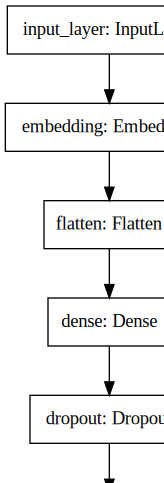

In [ ]:
Glove_model = Sequential()

Embed_Layer = Embedding(vocab_size, 100, weights = [embedding_matrix], input_length=(MAX_SEQ_LEN,), trainable = True)

input_layer = Input(shape=(MAX_SEQ_LEN,), dtype = 'int32', name='input_layer')
embedding_layer = Embed_Layer(input_layer)
Flatten_layer = Flatten()
flatten_layer = Flatten_layer(embedding_layer)
output_size = 7

dense1 = Dense(100, activation='relu')(flatten_layer)
dropout_layer1 = Dropout(0.3)(dense1)
dense2 = Dense(32, activation='relu')(dropout_layer1)
predict_layer = Dense(7, activation='softmax')(dense2)

Glove_model = Model(inputs = [input_layer], outputs = [predict_layer])
Glove_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

print(Glove_model.summary())
SVG(model_to_dot(Glove_model).create(prog='dot', format='svg'))

In [ ]:
history = Glove_model.fit(X_train, y_train, epochs = 10, batch_size=32, verbose=True, validation_data=(X_test, y_test))

Epoch 1/10
187/187 [==============================] - 7s 34ms/step - loss: 1.9640 - acc: 0.1812 - val_loss: 1.8710 - val_acc: 0.2403
Epoch 2/10
187/187 [==============================] - 6s 31ms/step - loss: 1.7875 - acc: 0.2998 - val_loss: 1.6621 - val_acc: 0.3530
Epoch 3/10
187/187 [==============================] - 6s 31ms/step - loss: 1.4869 - acc: 0.4424 - val_loss: 1.6030 - val_acc: 0.4000
Epoch 4/10
187/187 [==============================] - 6s 31ms/step - loss: 1.2144 - acc: 0.5499 - val_loss: 1.5307 - val_acc: 0.4282
Epoch 5/10
187/187 [==============================] - 6s 31ms/step - loss: 0.9249 - acc: 0.6651 - val_loss: 1.5970 - val_acc: 0.4430
Epoch 6/10
187/187 [==============================] - 6s 31ms/step - loss: 0.7153 - acc: 0.7380 - val_loss: 1.6521 - val_acc: 0.4638
Epoch 7/10
187/187 [==============================] - 6s 31ms/step - loss: 0.5183 - acc: 0.8275 - val_loss: 1.8009 - val_acc: 0.4671
Epoch 8/10
187/187 [==============================] - 6s 31ms/step - 

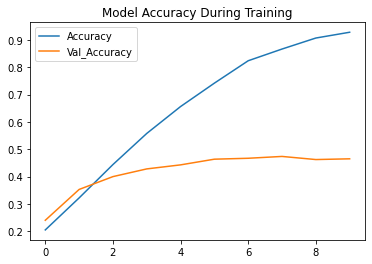

In [ ]:
import matplotlib.pyplot as plt

# Now, if we want to plot the model on the basis of the training and validation accuracy with respect to the no. of epochs, we can do as the following:
plt.title("Model Accuracy During Training")
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Val_Accuracy')
plt.legend()
plt.show()

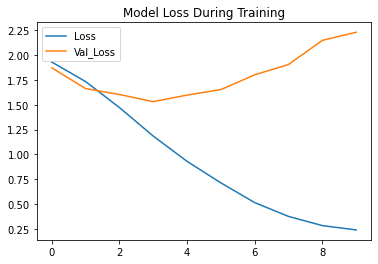

In [ ]:
# And, if we want to plot the model on the basis of the training and validation loss with respect to the no. of epochs, we can do as the following:
plt.title("Model Loss During Training")
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.show()

## **GLove + LSTM**

In [ ]:
# defining the embedding vector length as shape to the LSTM model
embedding_vector_length = 54

model = Sequential()
model.add(Input(shape=(MAX_SEQ_LEN,), dtype = 'int32'))

# The embedding layer is used to create the word vectors and such word vectors
model.add(Embedding(vocab_size, 100, weights = [embedding_matrix], input_length=(MAX_SEQ_LEN,), trainable = True))

# We have a long sequence lengths, so the model might get pretty dense
# when the model becomes heavy and complex,n model might overfit.
# so, we are adding a dropout layer as follows to avoid overfitting and boost training rate
# Here, 1D spatial dropout drops the entire 1D feature maps instead of individual elements
# like the regular dropout
model.add(SpatialDropout1D(0.25))

# Finally, we come to the backbone or the most important layer of the model
# Let's add a LSTM model with 50 units with dropout rate of 0.5 and recurrent dropout of 0.5
model.add(LSTM(35, dropout=0.5, recurrent_dropout=0.5))

# Also, to avoid the overfitting, we add a regular dropout layer with dropout rate of 0.2 as
model.add(Dropout(0.2))

# Now, we use a dense layer at the end of the LSTM network with one unit in the ouput layer
# The one unit gives the value. This value is interpreted by the loss function and
# we obtain a value as a result of the model. HeremDense layer with output units of 7 class
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['acc'])  

print(model.summary()) 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 178, 100)          906600    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 178, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 35)                19040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 252       
Total params: 925,892
Trainable params: 925,892
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
output_dir = "/content/drive/MyDrive/Output_Folder/"
model_name = "Glove+LSTM"

In [ ]:
from keras.callbacks import ModelCheckpoint
import os

history = model.fit(X_train, y_train, epochs = 25, batch_size=32, verbose=True, validation_data=(X_test, y_test),
                    callbacks=[ModelCheckpoint(os.path.join(output_dir, "{model_name}").format(model_name=model_name) + "-{epoch:02d}-{val_acc:.2f}.hdf5", save_best_only=True, verbose=True),
                                            ] if model_name is not None else [])

Epoch 1/25
187/187 [==============================] - 44s 218ms/step - loss: 1.9649 - acc: 0.1567 - val_loss: 1.8567 - val_acc: 0.2866

Epoch 00001: val_loss improved from inf to 1.85672, saving model to /content/drive/MyDrive/Output_Folder/Glove+LSTM-01-0.29.hdf5
Epoch 2/25
187/187 [==============================] - 45s 242ms/step - loss: 1.8628 - acc: 0.2448 - val_loss: 1.7408 - val_acc: 0.3228

Epoch 00002: val_loss improved from 1.85672 to 1.74076, saving model to /content/drive/MyDrive/Output_Folder/Glove+LSTM-02-0.32.hdf5
Epoch 3/25
187/187 [==============================] - 42s 223ms/step - loss: 1.7552 - acc: 0.3098 - val_loss: 1.5725 - val_acc: 0.3779

Epoch 00003: val_loss improved from 1.74076 to 1.57246, saving model to /content/drive/MyDrive/Output_Folder/Glove+LSTM-03-0.38.hdf5
Epoch 4/25
187/187 [==============================] - 41s 219ms/step - loss: 1.6349 - acc: 0.3748 - val_loss: 1.4846 - val_acc: 0.4336

Epoch 00004: val_loss improved from 1.57246 to 1.48463, savin

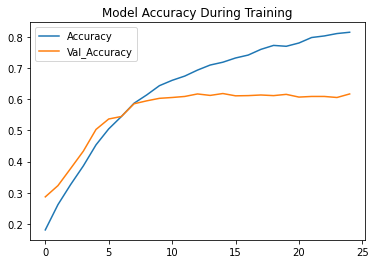

In [ ]:
plt.title("Model Accuracy During Training")
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Val_Accuracy')
plt.legend()
plt.show()

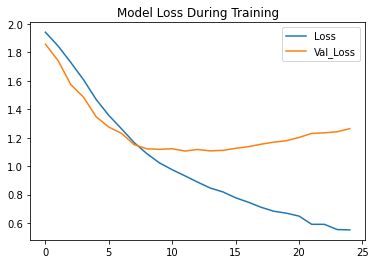

In [ ]:
plt.title("Model Loss During Training")
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.show()